In [66]:
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   -------------------------------------- - 286.7/294.9 kB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.6 MB 16.1 MB/s eta 0:00:01
   ---------- ----------------------------- 3.1/11.6 MB 32.7 MB/s eta 0:00:01
   ------------------ --------------------- 5.4/11.6 MB 43.0 MB/s eta 0:00:01
   --------------------- ------------------ 6.3/11.6 MB 33.4 MB/s eta 0:00:01
   ------------------------ --------------- 7.0/11.6 MB 32.0 MB/s eta 0:00:01
   ----------------------------- ---------- 8.7/11.6 MB 30.8 MB/s eta 0:00:01
   -------------------------------------- - 11.2/11.6 MB 38.6 MB/s eta 0:00:01
   ----------------

In [10]:

import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Load and Split the Dataset

In [3]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Ensure y is one-hot encoded
y_output = to_categorical(y_output, num_classes=4)

# Resizes images to 224 x 224 for optimal size for EfficientNetB1
x_input_resized = np.array([tf.image.resize(image, (224, 224)).numpy() for image in x_input])

# Split the data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input_resized, y_output, test_size=0.2, random_state=42)

# Printing Dimensions of data
print(f'X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}\n')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Testing Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

X Training Data
Number of Rows: 1536
Pixel Dimensions: 224x224x3

Y Training Data
Number of Rows: 1536
Number of Classes: 4

X Testing Data
Number of Rows: 384
Pixel Dimensions: 224x224x3

Y Testing Data
Number of Rows: 384
Number of Classes: 4


# Experimentation with Different Models under EfficientNet

## Custom Function to train and test initial models

In [96]:
def load_pretrained_model(version, input_shape=(224, 224, 3)):
    if version == 'B0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif version == 'B1':
        base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)
    elif version == 'B2':
        base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif version == 'B3':
        base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif version == 'B4':
        base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)
    
    pretrained_model = Model(inputs=base_model.input, outputs=base_model.output)
    return pretrained_model

def extract_features(model, data):
    features = model.predict(data)
    return features

versions = ['B0', 'B1', 'B2', 'B3', 'B4']
reports = {}

for version in versions:
    print(f"\nEvaluating EfficientNet{version}...\n")
    
    # Load the pretrained model
    pretrained_model = load_pretrained_model(version)
    
    # Extract features
    features_train = extract_features(pretrained_model, x_input_train)
    features_test = extract_features(pretrained_model, x_input_test)
    
    # Flatten the features for the classifier
    features_train_flat = features_train.reshape(features_train.shape[0], -1)
    features_test_flat = features_test.reshape(features_test.shape[0], -1)
    
    # Train a simple classifier
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(features_train_flat, np.argmax(y_output_train, axis=1))
    
    # Evaluate the classifier
    y_pred = classifier.predict(features_test_flat)
    y_true = np.argmax(y_output_test, axis=1)
    
    report = classification_report(y_true, y_pred, target_names=['No Tumor', 'Glioma', 'Meningioma', 'Pituitary'])
    reports[version] = report
    print(f"Classification Report for EfficientNet{version}:\n")
    print(report)




Evaluating EfficientNetB0...

48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 462ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step
Classification Report for EfficientNetB0:

              precision    recall  f1-score   support

    No Tumor       0.56      0.57      0.56        93
      Glioma       0.38      0.88      0.53        86
  Meningioma       0.36      0.04      0.08       112
   Pituitary       0.38      0.30      0.34        93

    accuracy                           0.42       384
   macro avg       0.42      0.45      0.38       384
weighted avg       0.42      0.42      0.36       384


Evaluating EfficientNetB1...

48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 646ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 618ms/step
Classification Report for EfficientNetB1:

              precision    recall  f1-score   support

    No Tumor       0.65      0.59      0.62        93
      Glioma       0.34      0.79      0.48        86
  Meningioma       0.45      0.12      0.18       112
   Pituitary       0.44      0.34 

c:\Users\User\anaconda3\envs\machinelearningmod\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for EfficientNetB3:

              precision    recall  f1-score   support

    No Tumor       0.69      0.57      0.62        93
      Glioma       0.49      0.77      0.60        86
  Meningioma       0.49      0.34      0.40       112
   Pituitary       0.60      0.62      0.61        93

    accuracy                           0.56       384
   macro avg       0.57      0.58      0.56       384
weighted avg       0.57      0.56      0.55       384


Evaluating EfficientNetB4...

48/48 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Classification Report for EfficientNetB4:

              precision    recall  f1-score   support

    No Tumor       0.72      0.53      0.61        93
      Glioma       0.50      0.83      0.62        86
  Meningioma       0.52      0.33      0.40       112
   Pituitary       0.58      0.65      0.61        93

    accuracy                           0.57       384
   macro avg       0.58      0.58      0.56 

c:\Users\User\anaconda3\envs\machinelearningmod\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Model Setup

In [13]:
# Load the EfficientNetB1 model with pretrained weights
effnet = EfficientNetB1(weights='imagenet',include_top=False,input_shape=(224,224,3))

# Add dropout layers and batch normalization
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy', Precision(name="precision"), Recall(name="recall")])
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001, mode='auto',verbose=1)
checkpoint = ModelCheckpoint("/model_checkpoints/efficientnetb1.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

print(len(model.layers))

343


# Model Training + Active Tuning

In [14]:
# Train the model with the initial layers frozen
history = model.fit(
    x_input_train, y_output_train,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=(x_input_test, y_output_test),
    callbacks=[checkpoint,reduce_lr]
)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7121 - loss: 0.6922 - precision: 0.8423 - recall: 0.6091
Epoch 1: val_accuracy improved from -inf to 0.22396, saving model to /model_checkpoints/efficientnetb1.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.7148 - loss: 0.6866 - precision: 0.8436 - recall: 0.6130 - val_accuracy: 0.2240 - val_loss: 3.7858 - val_precision: 0.2240 - val_recall: 0.2240 - learning_rate: 0.0010
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9666 - loss: 0.1241 - precision: 0.9677 - recall: 0.9645
Epoch 2: val_accuracy did not improve from 0.22396
48/48 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.9665 - loss: 0.1242 - precision: 0.9676 - recall: 0.9644 - val_accuracy: 0.2240 - val_loss: 2.0356 - val_precision: 0.2240 - val_recall: 0.2240 - learning_rate: 0.0010
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9780 - loss: 0.0650 - precision: 0.9797 - recall: 0.9778
Epoch 3: val_accuracy did not improv

In [15]:
# Save the model
model.save("model_checkpoints/efficientnetb1.keras")

In [16]:
import json

history_dict = history.history

# Save the history dictionary to a JSON file
with open('model_history/training_history.json', 'w') as f:
    json.dump(history_dict, f)

In [ ]:
# Load the history dictionary from the JSON file
with open('model_history/training_history.json', 'r') as f:
    loaded_history_dict = json.load(f)

class History:
    def __init__(self):
        self.history = {}

loaded_history = History()
loaded_history.history = loaded_history_dict

# Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Meningioma


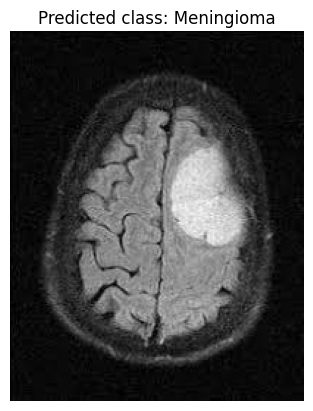

In [12]:
# Define class names based on your dataset's mapping
class_names = ['No Tumor', 'Glioma', 'Meningioma', 'Pituitary']

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path).convert('RGB')
    
    # Resize the image
    img = img.resize(target_size)
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Normalize the image
    img_array = img_array / 255.0
    
    # Expand dimensions to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def display_image_with_prediction(image_path, predicted_class, class_names):
    # Load the image
    img = Image.open(image_path)
    
    # Display the image
    plt.imshow(img)
    plt.title(f'Predicted class: {class_names[predicted_class]}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'data/meningioma/Te-me_0082.jpg'
preprocessed_image = load_and_preprocess_image(image_path)

# Make predictions on the preprocessed image
predictions = model.predict(preprocessed_image)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)[0]

# Print the predicted class
print(f'Predicted class: {class_names[predicted_class]}')

# Display the image with prediction
display_image_with_prediction(image_path, predicted_class, class_names)


## Further multiple predictions using NPY files

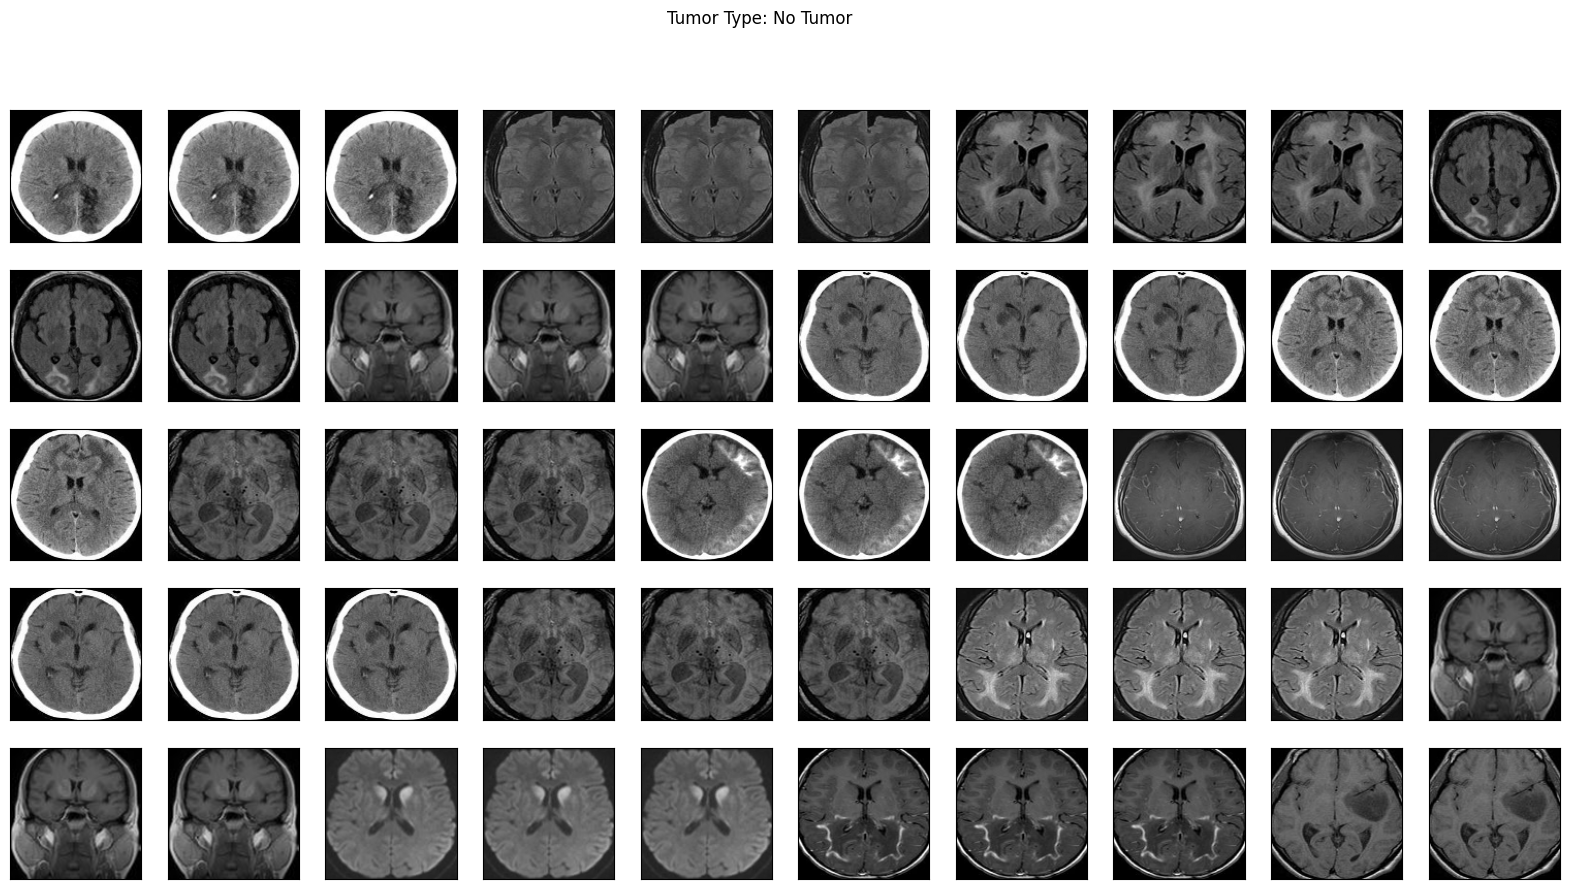

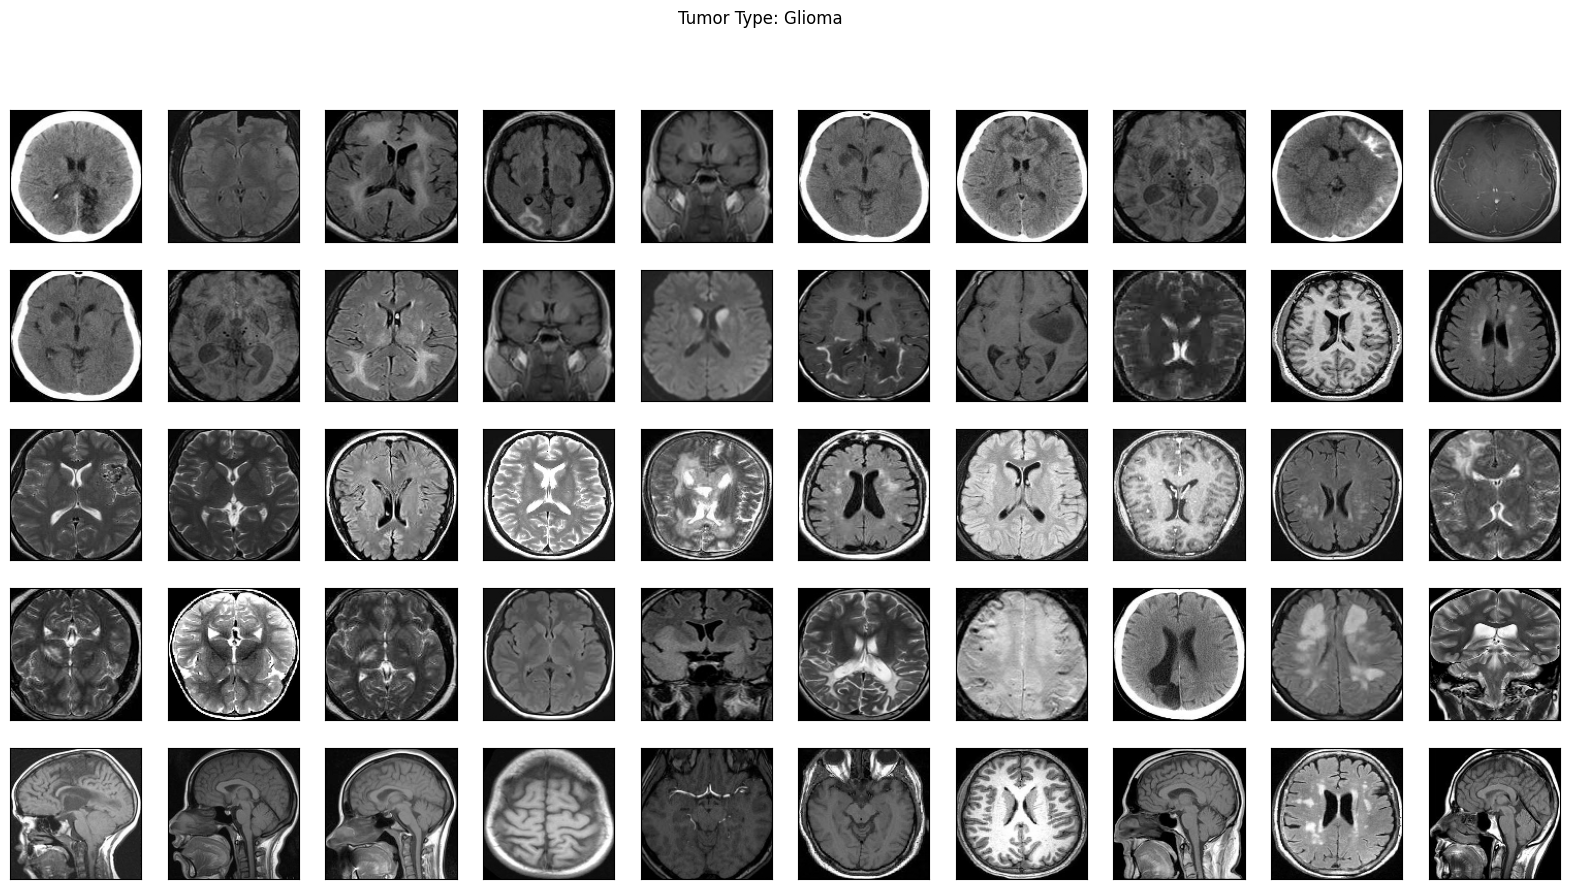

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 690ms/step
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        93
      Glioma       0.00      0.00      0.00        86
  Meningioma       0.29      1.00      0.45       112
   Pituitary       0.00      0.00      0.00        93

    accuracy                           0.29       384
   macro avg       0.07      0.25      0.11       384
weighted avg       0.09      0.29      0.13       384



c:\Users\User\anaconda3\envs\machinelearningmod\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\machinelearningmod\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\machinelearningmod\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

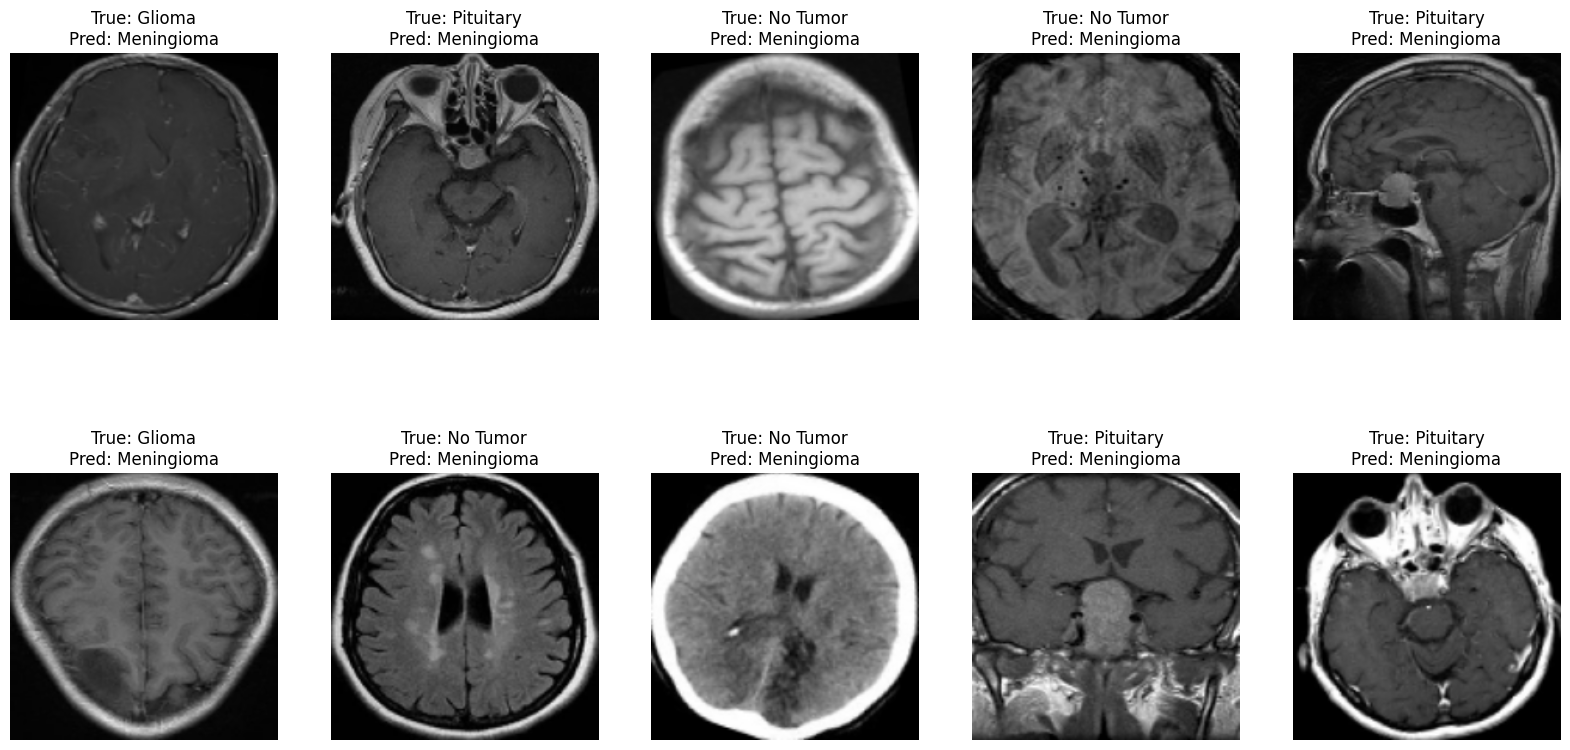

In [16]:


# Define class names based on your dataset's mapping
class_names = ['No Tumor', 'Glioma', 'Meningioma', 'Pituitary']

def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for each unique label in y.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    # Define a mapping from label to string representation
    label_to_str = {0: "No Tumor", 1: "Glioma", 2: "Meningioma", 3: "Pituitary"}
    
    # Iterate over all unique labels in y
    for label in np.unique(y):
        # Grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(np.ceil(n / columns_n))

        plt.figure(figsize=(20, 10))
        
        i = 1  # Current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # Remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        plt.suptitle(f"Tumor Type: {label_to_str[label]}")
        plt.show()

# Plot sample images
plot_sample_images(x_input, y_output, n=50)

# Get the predicted classes
y_pred = model.predict(x_input_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_output_test, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)

# Visualize some predictions
def plot_predictions(x_input_test, y_true_classes, y_pred_classes, class_names, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(x_input_test[i])
        plt.title(f'True: {class_names[y_true_classes[i]]}\nPred: {class_names[y_pred_classes[i]]}')
        plt.axis('off')
    plt.show()

plot_predictions(x_input_test, y_true_classes, y_pred_classes, class_names)


In [15]:

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Assuming history is the variable that stores the training history
plot_training_history(history)

NameError: name 'history' is not defined

# Evaluation

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 689ms/step


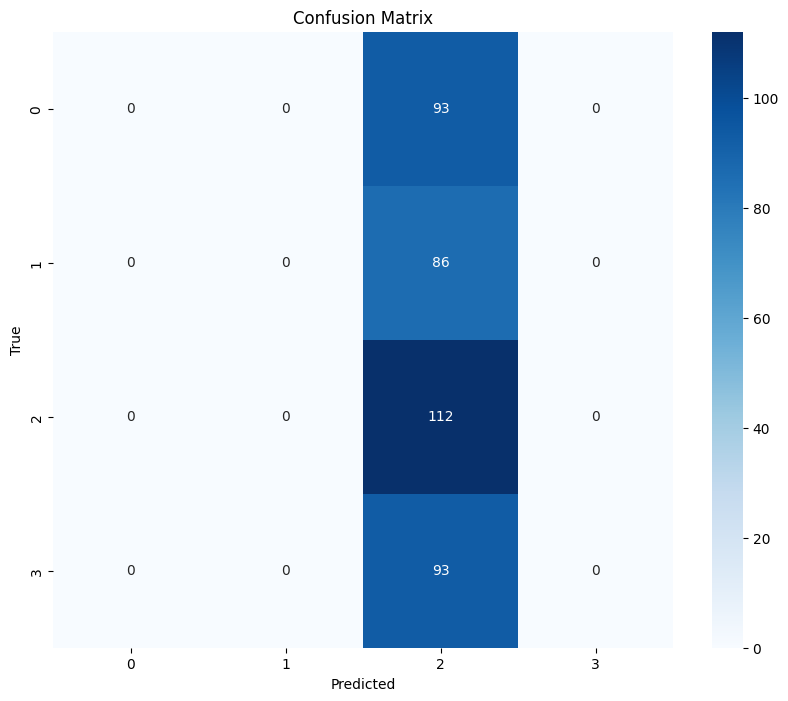

Weighted F1 Score: 0.13


In [14]:


# Get the predicted classes
y_pred = model.predict(x_input_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_output_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate the F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')


In [10]:


# Assuming your model is already trained and x_input_test, y_output_test are your test data and labels
# Get the predicted classes
y_pred = model.predict(x_input_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_output_test, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 629ms/step
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        93
     Class 1       0.00      0.00      0.00        86
     Class 2       0.29      1.00      0.45       112
     Class 3       0.00      0.00      0.00        93

    accuracy                           0.29       384
   macro avg       0.07      0.25      0.11       384
weighted avg       0.09      0.29      0.13       384



c:\Users\User\anaconda3\envs\machinelearningmod\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\machinelearningmod\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\machinelearningmod\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

c:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  0
